In [1]:
import torch
import torch.tensor as tensor
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler, BatchSampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.models as M
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import PIL
import torch.nn.functional as F  # useful stateless functions
from torchsummary import summary

import numpy as np
import os
import time

from pytorch_utils.utils.torch_utils import show_img, train_model, evaluate_model
from common_utils.ml_analytics import analyze_predictions, visualize_predictions
plt.ion()   # interactive mode

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.multiprocessing.set_sharing_strategy('file_system')
dtype = torch.float32 # we will be using float throughout this tutorial
print('using device:', device)

using device: cuda:0


In [3]:
NUM_TRAIN = 49000
bs = 32
size = 224

mean = [0.48901841044425964, 0.47498565912246704, 0.4390876591205597]
std = [0.1923810839653015, 0.1894422471523285, 0.18973302841186523]


dset_names = ['train', 'val', 'test']

train_transforms = [# T.Resize(size),
                    T.RandomResizedCrop(size, scale=(0.5, 1)),
#                     T.RandomHorizontalFlip(),
                    T.ToTensor(),
                    T.Normalize(mean, std)
                   ]

use_ten_crops = False
from_saved_images = False

if use_ten_crops:
    val_transforms = [
            T.TenCrop(24),
            T.Lambda(lambda crops: torch.stack([T.ToTensor()(T.Resize(size)(crop)) for crop in crops])),
            T.Lambda(lambda crops: torch.stack([T.Normalize(mean, std)(crop) for crop in crops]))
        ]
else:
    val_transforms = [T.Resize(size), T.ToTensor(), T.Normalize(mean, std)]

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': T.Compose(train_transforms),
    'val': T.Compose(val_transforms),
}
data_transforms['test'] = data_transforms['val']


from_train = dict(zip(dset_names, [True, True, False]))
if from_saved_images:
    data_dir = '/home/abdelrhman/data/cifar_10/'
    image_datasets = {x: dset.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in dset_names}
    sampler = dict(zip(dset_names, [SubsetRandomSampler(range(NUM_TRAIN)), SubsetRandomSampler(range(NUM_TRAIN, 50000)), None]))
    dataloaders = {x: DataLoader(image_datasets[x], batch_size=bs, sampler=sampler[x], num_workers=4) for x in dset_names}
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
else:
    data_dir = '../assignment1/cs231n/datasets'
    image_datasets = {x: dset.CIFAR10(data_dir, train=from_train[x], download=True, transform=data_transforms[x]) for x in dset_names}
    sampler = dict(zip(dset_names, [SubsetRandomSampler(range(NUM_TRAIN)), SubsetRandomSampler(range(NUM_TRAIN, 50000)), None]))
    dataloaders = {x: DataLoader(image_datasets[x], batch_size=bs, sampler=sampler[x], num_workers=4) for x in dset_names}
    class_names = image_datasets['train'].classes
# dataset_sizes = {x: len(dataloaders[x]) for x in dset_names}


print("class_names = {}".format(class_names))
# print("dataset_sizes = {}".format(dataset_sizes))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


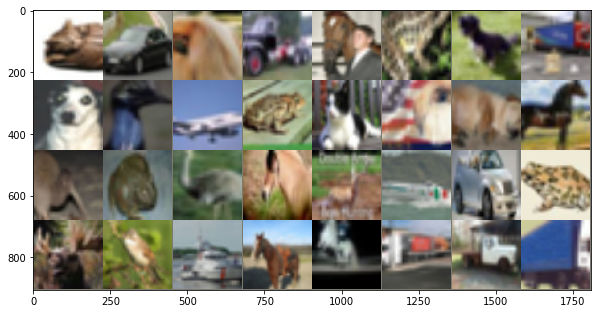

In [4]:
data = iter(dataloaders['train'])
images, labels = next(data)

calc_stats = False
if calc_stats:
    mean, std = tensor((0.0, 0.0, 0.0)), tensor((0.0, 0.0, 0.0))
    for images, _ in data:
        n, c, h, w = images.shape
        mean += images.mean(0).mean(1).mean(1)
        std += images.view(n, c, -1).std(2).mean(0)
    mean = mean.cpu().numpy() / len(data)
    std = std.cpu().numpy() / len(data)
    print("mean = [{}, {}, {}]\nstd = [{}, {}, {}]".format(mean[0], mean[1], mean[2], std[0], std[1], std[2]))

# show images
grid = make_grid(images)
show_img(grid, mean=mean, std=std, fig_sz=(10, 10))

In [5]:
from pytorch_utils.classifiers.torch_layers import ConvParams, ConvRelUx2_MaxPool2, MiniInception

learning_rate = 1e-3
num_epochs = 10

    
conv_params_list = [ConvParams(8, 3), ConvParams(16, 3),  # 16, 1M
                   ConvParams(32, 3), ConvParams(64, 3),  # 8, 5M
                   ConvParams(128, 3), ConvParams(256, 3)]  # 4, 23M


# model = nn.Sequential(*ConvRelUx2_MaxPool2(conv_params_list, [512]*2)) #2M
# model_name = 'ConvRelUx2_MaxPool2'

model = M.densenet121(pretrained=True, memory_efficient=False)
# print(model)

children = next(iter(model.children()))
# first DenseBlock is at i = 4, last(4th) DenseBlock is at i = 7
# Thus this freezes all blocks excep last DenseBlock onwards.
for i, child in enumerate(children):
    for param in child.parameters():
        param.require_grad = False
    if i == 6:
        break
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 10)
# print(model)
# model.to(device=device)
# summary(model, (3, 224, 224))
model_name = 'pretrained_densenet121_ft_last_denseblock_insize_224_bs_64_from_saved_imgs'

dir_name = '/home/abdelrhman/loggings/'
logs = dir_name + model_name + '/'

# model = MiniInception(10)
# logs = '/home/abdelrhman/loggings/MiniInception'

optimizer = optim.Adam(model.parameters(), lr=1e-3)
# optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=1, factor=0.5)
loss = F.cross_entropy

In [ ]:
from_saved_model = False
if from_saved_model:
    model.load_state_dict(torch.load(logs + '/model'))
    model.eval()
else:
    model = train_model(dataloaders['train'], dataloaders['val'], model, loss, optimizer, scheduler, num_epochs, logs,
                        device=device, dtype=dtype, use_ten_crops=use_ten_crops)
    torch.save(model.state_dict(), logs + '/model')

Epoch 0/9
----------
train Loss: 0.8063 Acc: 0.7208
val Loss: 0.4925 Acc: 0.8260
elapsed_time = 772s

Epoch 1/9
----------


In [ ]:
imgs, preds, labels = evaluate_model(dataloaders['val'], model, n_batches=1,
                                     mean=mean, std=std, use_ten_crops=use_ten_crops, device=device)
analyze_predictions(preds, labels, class_names)

In [ ]:
visualize_predictions(imgs, preds, class_names=class_names, true_labels=labels, samples_per_class=7, num_classes=len(class_names))